# Forecasting com Eventos (Incluindo Natal)

## Importações e Configurações

In [1]:
import os

# Google Cloud Platform
from google.cloud import bigquery
from google.oauth2 import service_account

# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import seaborn as sns

# Bibliotecas para modelagem
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Importação do Prophet
from prophet import Prophet

# Configurar parâmetros de exibição
%matplotlib inline
sns.set(style='whitegrid')

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Conexão com o Banco de Dados

In [2]:
# Caminho para o arquivo de chave da conta de serviço
service_account_path = 'tfm-sa.json'

# Criar objeto de credenciais
credentials = service_account.Credentials.from_service_account_file(service_account_path)

# Configurações do projeto e dataset
project_id = 'perseverance-332400'
dataset_id = 'TFM'
table_id = 'ds_market'
full_table_id = f'{project_id}.{dataset_id}.{table_id}'

# Criar cliente BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

## Carregamento e Preparação dos Dados

In [3]:
# Definir a consulta SQL para carregar os dados
query = f"""
SELECT *
FROM `{full_table_id}`
"""

# Executar a consulta e carregar os dados em um DataFrame pandas
df = client.query(query).to_dataframe()

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [4]:
# Garantir que a coluna 'date' esteja em formato de data
df['date'] = pd.to_datetime(df['date'])

# Definir a coluna 'date' como índice
df.set_index('date', inplace=True)

# Verificar valores faltantes
print("Valores faltantes por coluna:")
print(df.isnull().sum())

Valores faltantes por coluna:
id                   0
item                 0
category_x           0
department           0
store                0
store_code           0
region               0
d                    0
sales                0
yearweek             0
event         57561115
category_y    12513532
sell_price    12513532
dtype: int64


## Inclusão do Evento "Natal"

In [5]:
def adicionar_eventos(df):
    if 'event' not in df.columns:
        df['event'] = None
    natal_dates = pd.to_datetime([
        '2011-12-25', '2012-12-25', '2013-12-25',
        '2014-12-25', '2015-12-25', '2016-12-25'
    ])
    df.loc[df.index.isin(natal_dates), 'event'] = 'Natal'
    return df

# Adicionar o evento "Natal"
df = adicionar_eventos(df)

# Codificar a coluna 'event' usando One-Hot Encoding, sem dummy_na
df = pd.get_dummies(df, columns=['event'])

## Selecionar os Top 10 Itens Mais Vendidos

In [6]:
# Calcular as vendas totais por item
top_items = df.groupby('item')['sales'].sum().sort_values(ascending=False).head(10).index

# Filtrar o DataFrame para incluir apenas os top 10 itens
df_top_items = df[df['item'].isin(top_items)]

## Análise por Loja

In [7]:
# Selecionar uma loja específica (por exemplo, 'Queen_Village')
store_name = 'Queen_Village'
df_store = df_top_items[df_top_items['store'] == store_name]

## Dados Diários e Preparação de Variáveis Exógenas

In [8]:
# Não agregue os dados; mantenha-os na frequência diária
daily_sales = df_store.copy()

# Identificar variáveis exógenas (eventos)
exog_vars = [col for col in daily_sales.columns if 'event_' in col]

# Não é necessário resetar o índice aqui, pois já o faremos depois

# Separar ano e mês para facilitar
daily_sales['year'] = daily_sales.index.year
daily_sales['month'] = daily_sales.index.month

## Funções Auxiliares

In [9]:
def verificar_estacionariedade(series):
    result = adfuller(series)
    print('Estatística ADF:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critério {}: {}'.format(key, value))

def preparar_variaveis_exogenas_futuras(exog_vars, start_date, periods, freq='D'):
    future_dates = pd.date_range(start=start_date, periods=periods, freq=freq)
    future_exog = pd.DataFrame(index=future_dates)
    for var in exog_vars:
        future_exog[var] = 0  # Inicialmente zero
    future_exog['event_Natal'] = 0
    future_exog.loc[(future_exog.index.month == 12) & (future_exog.index.day == 25), 'event_Natal'] = 1
    return future_exog

## Função para Treinar o Modelo SARIMAX e Fazer Previsões

In [12]:
def train_and_forecast(item_df, item_name):
    # Separar as variáveis exógenas (eventos)
    exog_vars = [col for col in item_df.columns if 'event_' in col]
    
    # Dividir em treino e teste
    train = item_df[item_df['year'] < 2016]
    test = item_df[item_df['year'] == 2016]
    
    # Preparar as variáveis dependentes e independentes
    y_train = train['sales']
    X_train = train[exog_vars]
    y_test = test['sales']
    X_test = test[exog_vars]
    
    # Verificar estacionariedade
    print(f'\nVerificando estacionariedade para o item: {item_name}')
    verificar_estacionariedade(y_train)
    
    # Selecionar o melhor modelo usando auto_arima
    print(f'\nSelecionando o melhor modelo para o item: {item_name}')
    stepwise_fit = auto_arima(
        y_train,
        exogenous=X_train,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        m=7,  # Sazonalidade semanal (dados diários)
        seasonal=True,
        d=1, D=1,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    
    print(stepwise_fit.summary())
    
    # Fazer previsões no conjunto de teste
    y_pred = stepwise_fit.predict(n_periods=len(y_test), exogenous=X_test)
    
    # Avaliar o modelo
    mse = ((y_pred - y_test.values) ** 2).mean()
    mae = np.mean(np.abs(y_pred - y_test.values))
    print(f'\nItem: {item_name} - MSE: {mse:.2f}, MAE: {mae:.2f}')
    
    # Plotar resultados
    plt.figure(figsize=(12,6))
    plt.plot(y_train.index, y_train, label='Treino')
    plt.plot(y_test.index, y_test, label='Teste')
    plt.plot(y_test.index, y_pred, label='Previsão')
    plt.title(f'Previsão de Vendas Diárias para {item_name}')
    plt.legend()
    plt.show()
    
    # Fazer previsão para os próximos 28 dias
    future_exog = preparar_variaveis_exogenas_futuras(
        exog_vars, start_date=y_test.index[-1] + pd.Timedelta(days=1), periods=28
    )
    future_forecast = stepwise_fit.predict(n_periods=28, exogenous=future_exog)
    
    # Criar DataFrame com as previsões futuras
    future_dates = future_exog.index
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast})
    forecast_df.set_index('date', inplace=True)
    
    # Plotar previsões futuras
    plt.figure(figsize=(12,6))
    plt.plot(y_train.index, y_train, label='Treino')
    plt.plot(y_test.index, y_test, label='Teste')
    plt.plot(y_test.index, y_pred, label='Previsão')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Previsão Futura')
    plt.title(f'Previsão de Vendas Futura para {item_name}')
    plt.legend()
    plt.show()
    
    # Retornar as previsões futuras
    return forecast_df

## Aplicar a Função para Cada Item


Treinando modelo para o item: SUPERMARKET_3_090

Verificando estacionariedade para o item: SUPERMARKET_3_090
Estatística ADF: -26.658961559016326
p-value: 0.0
Critério 1%: -3.4339012073737605
Critério 5%: -2.8631086593659174
Critério 10%: -2.567605099413705

Selecionando o melhor modelo para o item: SUPERMARKET_3_090
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1847
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -10491.706
Date:                           Wed, 23 Oct 2024   AIC                          20995.412
Time:                                   15:29:51   BIC                          21028.514
Sample:                                        0   HQIC                         21007.618
                                          - 1847                                         
Covariance Type:                             opg  

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


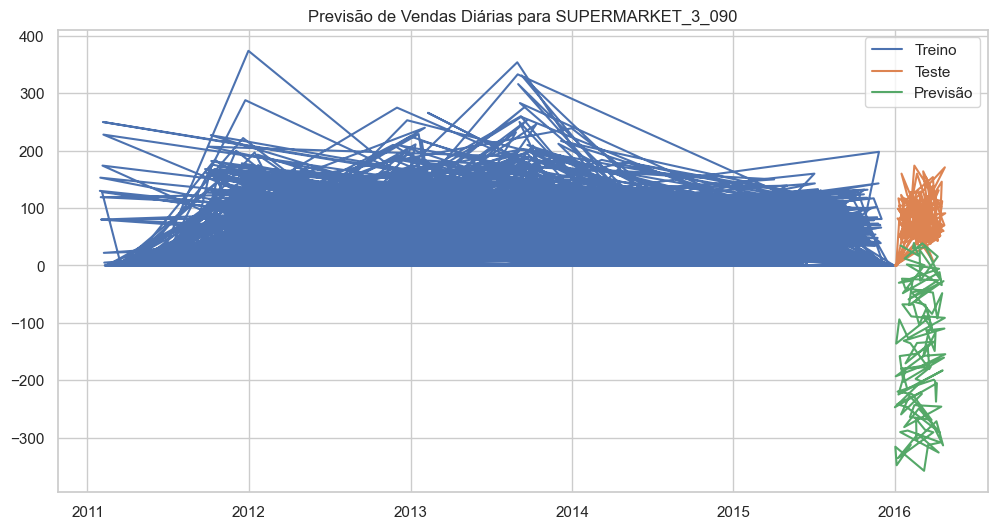

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


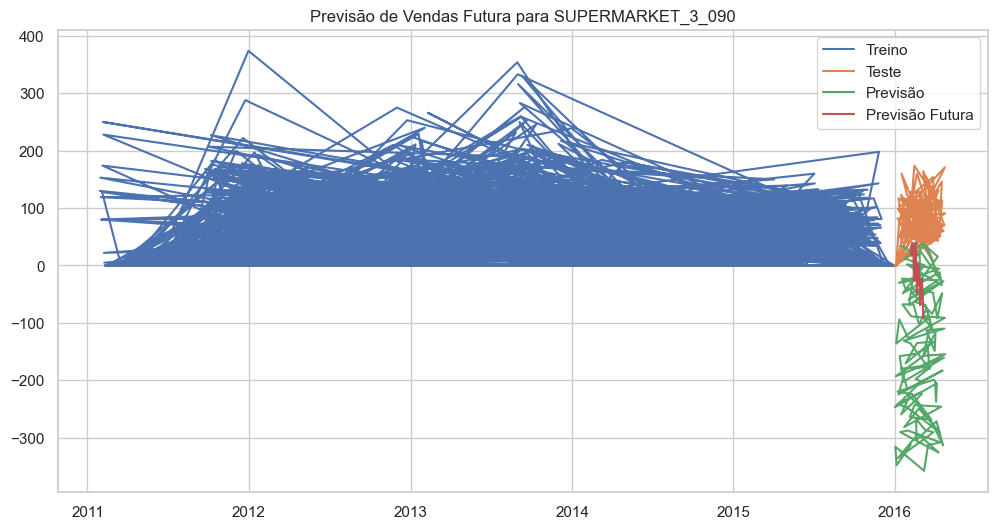


Treinando modelo para o item: SUPERMARKET_3_586

Verificando estacionariedade para o item: SUPERMARKET_3_586
Estatística ADF: -15.462871961318797
p-value: 2.691528529810341e-28
Critério 1%: -3.434006447337251
Critério 5%: -2.863155118104396
Critério 10%: -2.567629837184558

Selecionando o melhor modelo para o item: SUPERMARKET_3_586
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -8243.217
Date:                           Wed, 23 Oct 2024   AIC                          16498.434
Time:                                   15:30:23   BIC                          16531.374
Sample:                                        0   HQIC                         16510.597
                                          - 1798                                         
Covariance Type:                  

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


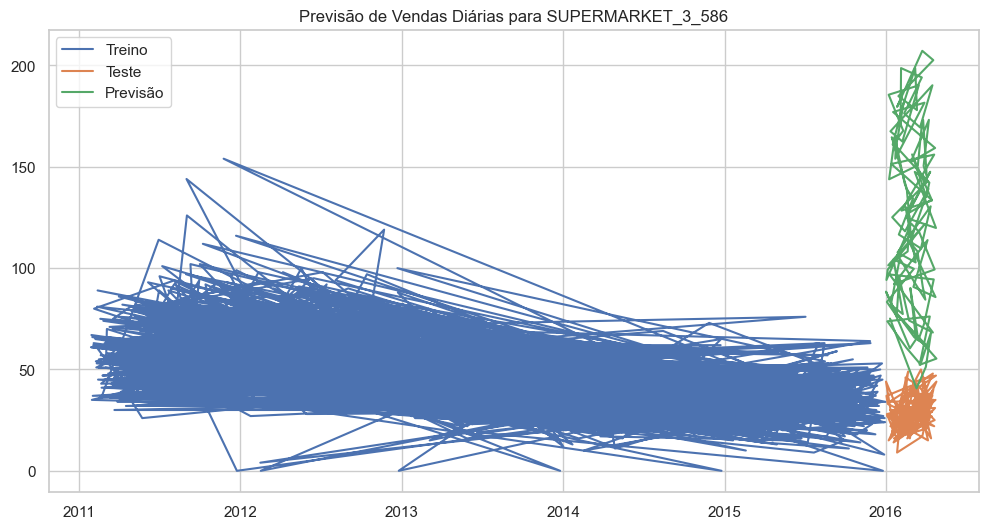

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


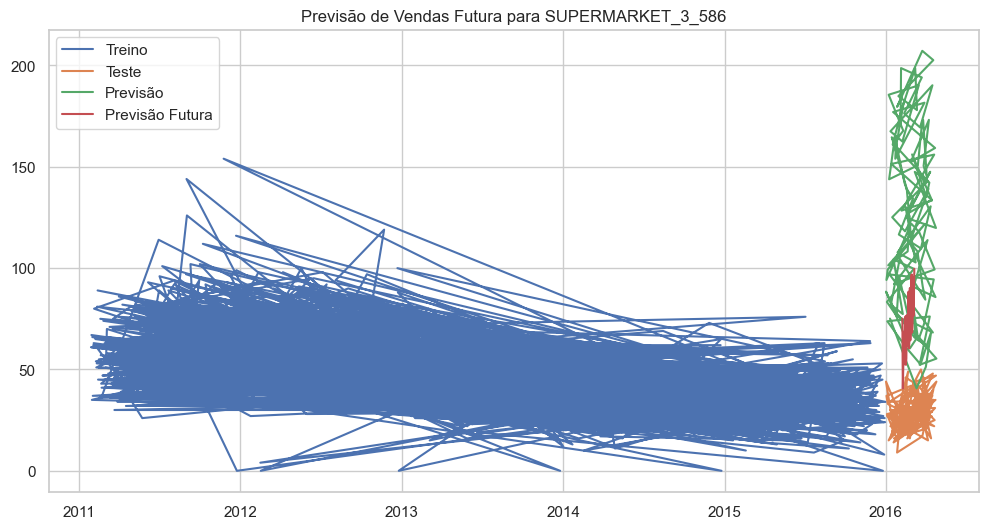


Treinando modelo para o item: SUPERMARKET_3_252

Verificando estacionariedade para o item: SUPERMARKET_3_252
Estatística ADF: -22.74982704929717
p-value: 0.0
Critério 1%: -3.4339982875683357
Critério 5%: -2.863151515989605
Critério 10%: -2.567627919165742

Selecionando o melhor modelo para o item: SUPERMARKET_3_252
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7348.916
Date:                           Wed, 23 Oct 2024   AIC                          14709.833
Time:                                   15:30:57   BIC                          14742.772
Sample:                                        0   HQIC                         14721.995
                                          - 1798                                         
Covariance Type:                             opg    

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


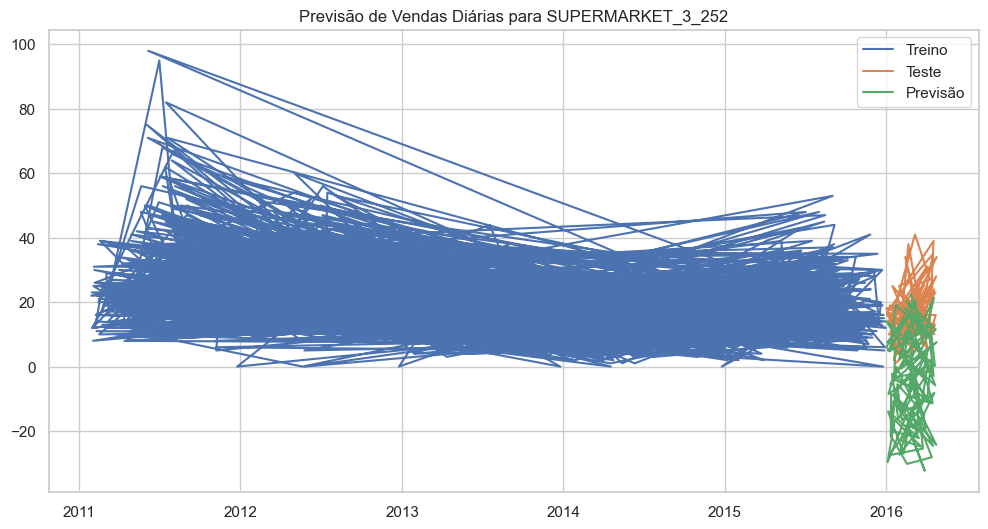

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


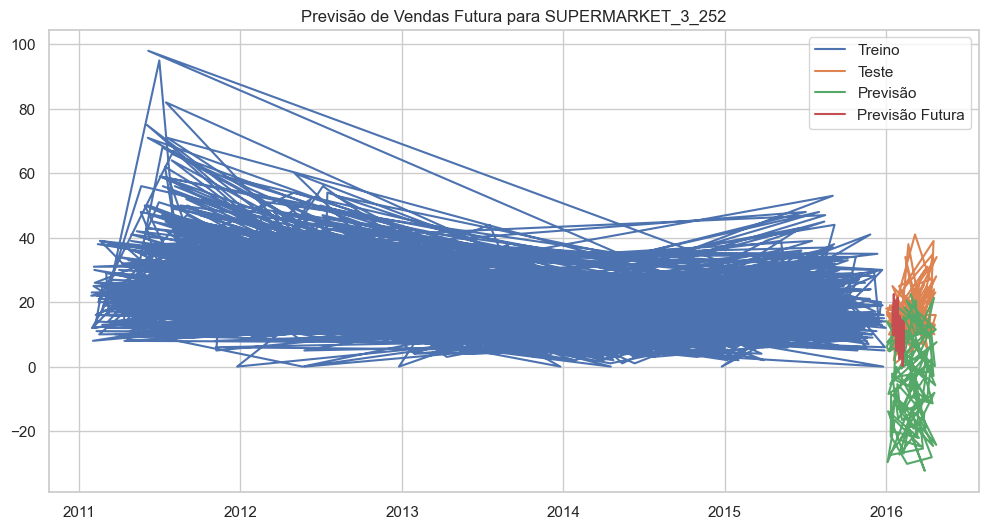


Treinando modelo para o item: SUPERMARKET_3_555

Verificando estacionariedade para o item: SUPERMARKET_3_555
Estatística ADF: -18.44820100717945
p-value: 2.1558381355706353e-30
Critério 1%: -3.434006447337251
Critério 5%: -2.863155118104396
Critério 10%: -2.567629837184558

Selecionando o melhor modelo para o item: SUPERMARKET_3_555
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7963.175
Date:                           Wed, 23 Oct 2024   AIC                          15938.349
Time:                                   15:31:24   BIC                          15971.289
Sample:                                        0   HQIC                         15950.512
                                          - 1798                                         
Covariance Type:                  

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


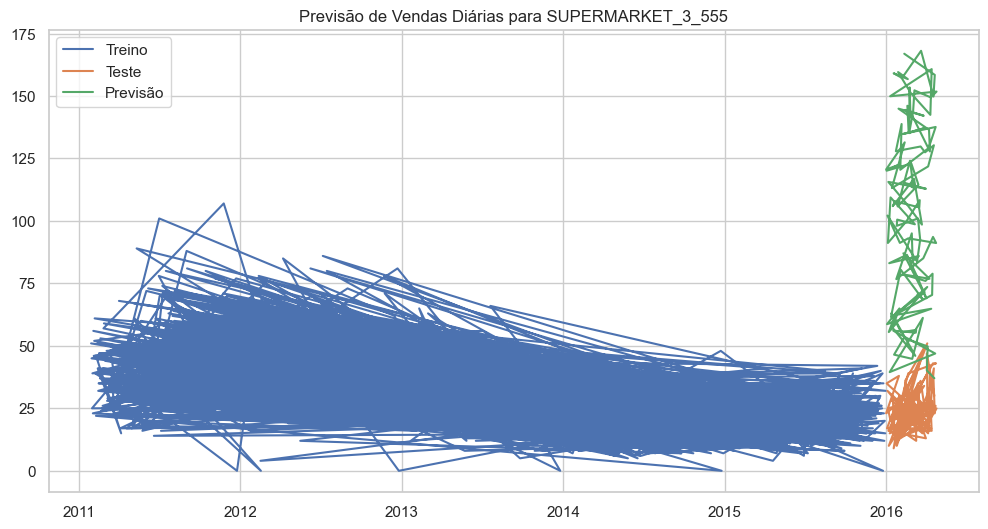

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


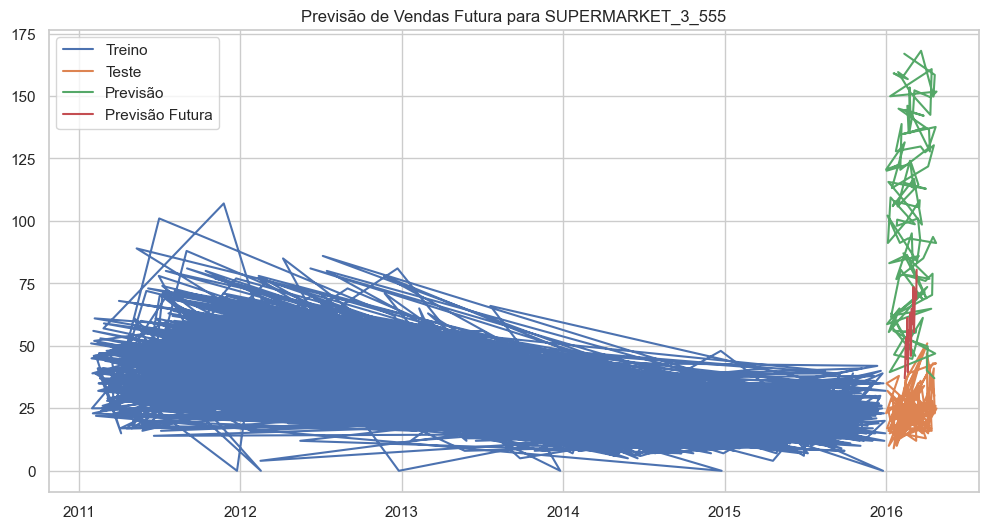


Treinando modelo para o item: SUPERMARKET_3_714

Verificando estacionariedade para o item: SUPERMARKET_3_714
Estatística ADF: -22.358999192715565
p-value: 0.0
Critério 1%: -3.4339982875683357
Critério 5%: -2.863151515989605
Critério 10%: -2.567627919165742

Selecionando o melhor modelo para o item: SUPERMARKET_3_714
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7681.150
Date:                           Wed, 23 Oct 2024   AIC                          15374.301
Time:                                   15:31:50   BIC                          15407.241
Sample:                                        0   HQIC                         15386.464
                                          - 1798                                         
Covariance Type:                             opg   

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


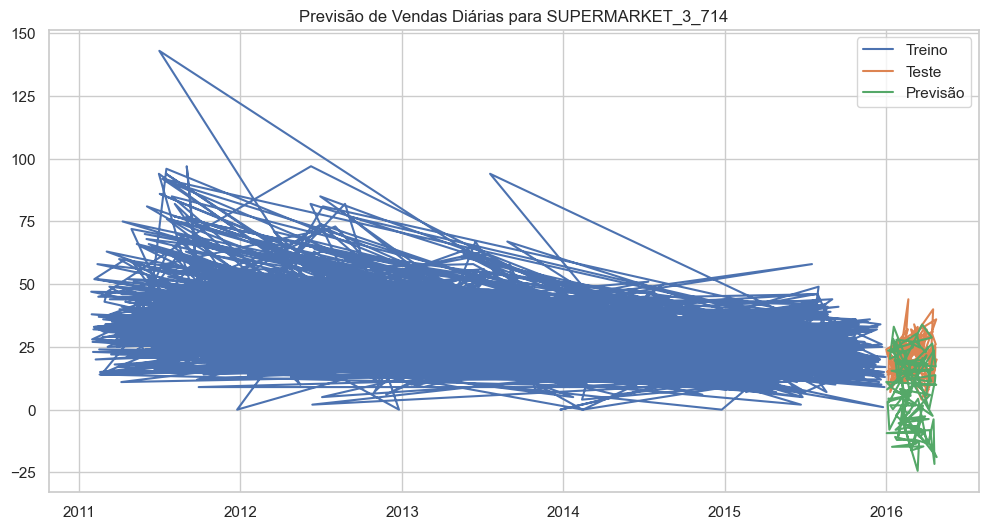

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


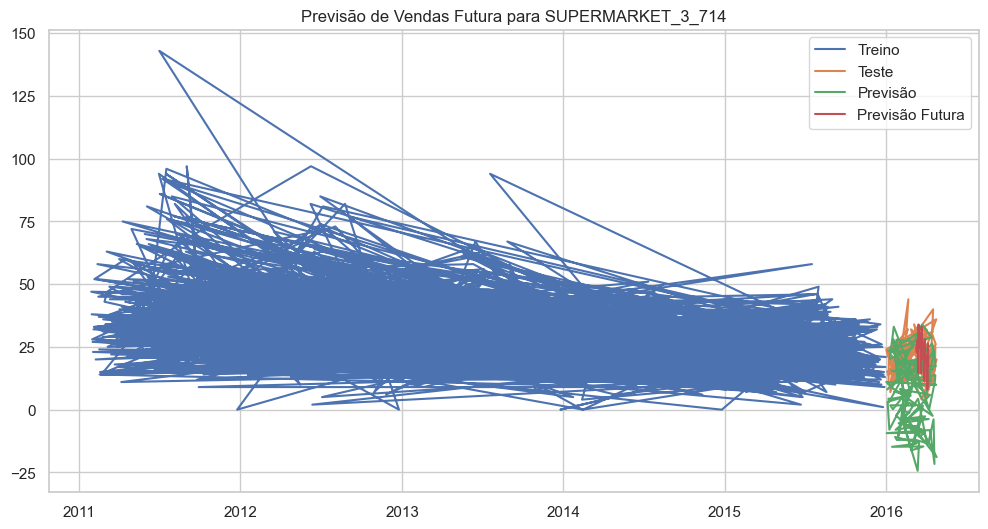


Treinando modelo para o item: SUPERMARKET_3_587

Verificando estacionariedade para o item: SUPERMARKET_3_587
Estatística ADF: -19.372899875410635
p-value: 0.0
Critério 1%: -3.434002362895342
Critério 5%: -2.863153315036348
Critério 10%: -2.5676288771043367

Selecionando o melhor modelo para o item: SUPERMARKET_3_587
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -8044.912
Date:                           Wed, 23 Oct 2024   AIC                          16101.823
Time:                                   15:32:17   BIC                          16134.763
Sample:                                        0   HQIC                         16113.986
                                          - 1798                                         
Covariance Type:                             opg   

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


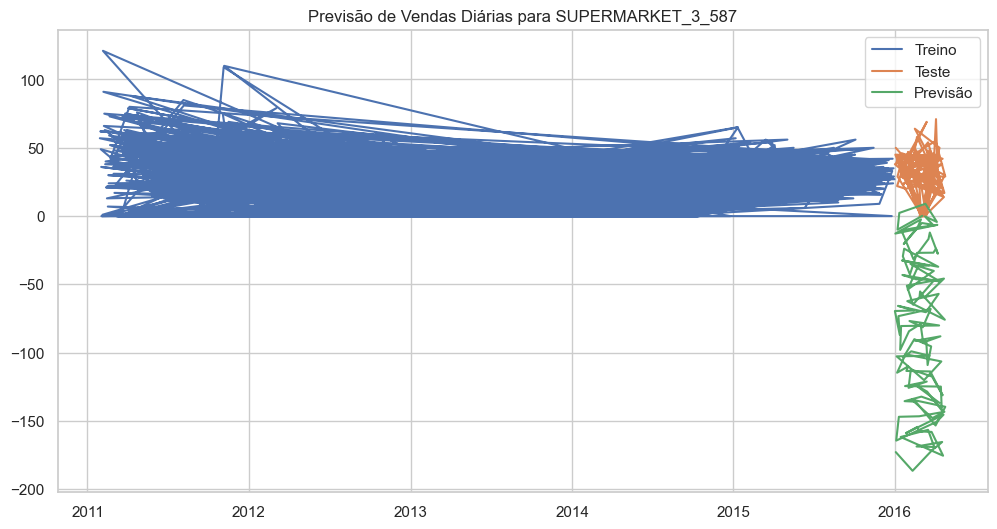

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


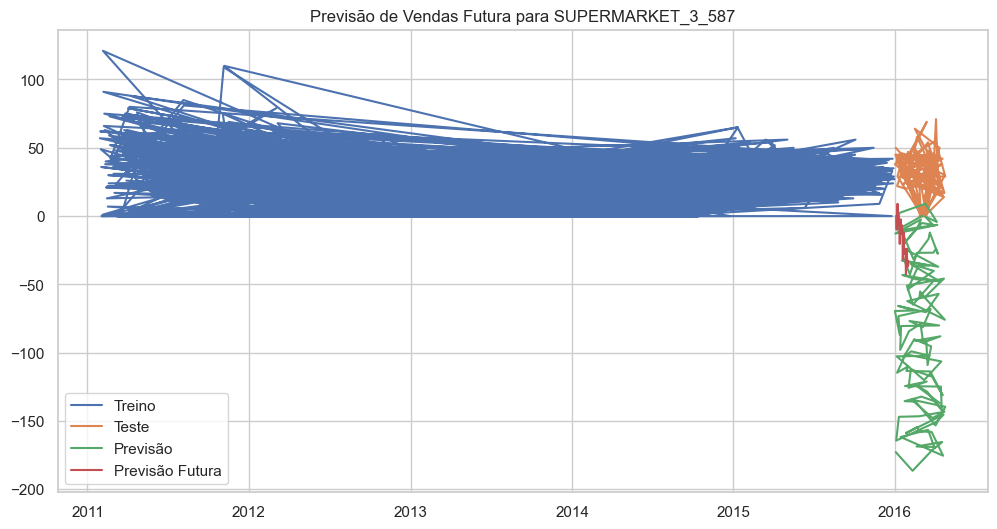


Treinando modelo para o item: SUPERMARKET_3_694

Verificando estacionariedade para o item: SUPERMARKET_3_694
Estatística ADF: -42.684804443531476
p-value: 0.0
Critério 1%: -3.4339942213257535
Critério 5%: -2.8631497209507284
Critério 10%: -2.567626963361616

Selecionando o melhor modelo para o item: SUPERMARKET_3_694
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7586.700
Date:                           Wed, 23 Oct 2024   AIC                          15185.400
Time:                                   15:32:50   BIC                          15218.340
Sample:                                        0   HQIC                         15197.563
                                          - 1798                                         
Covariance Type:                             opg  

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


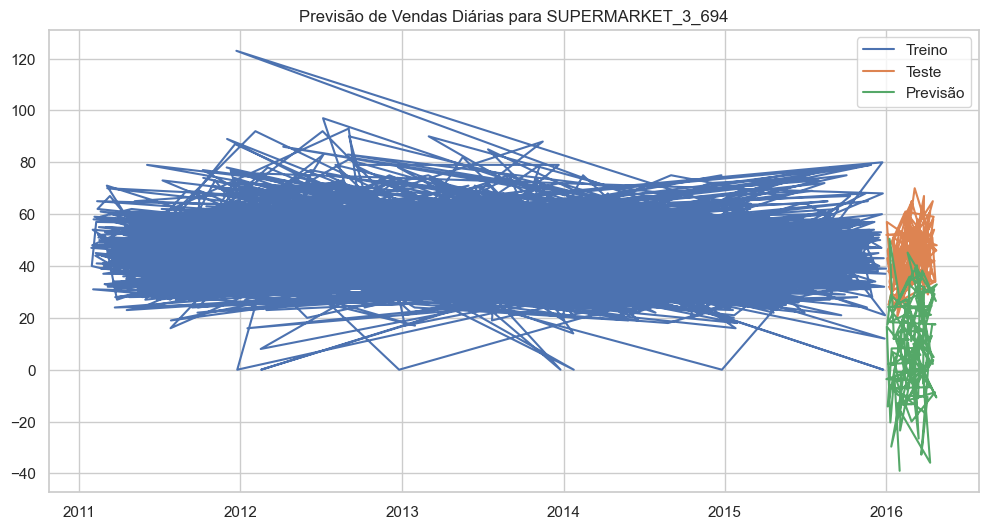

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


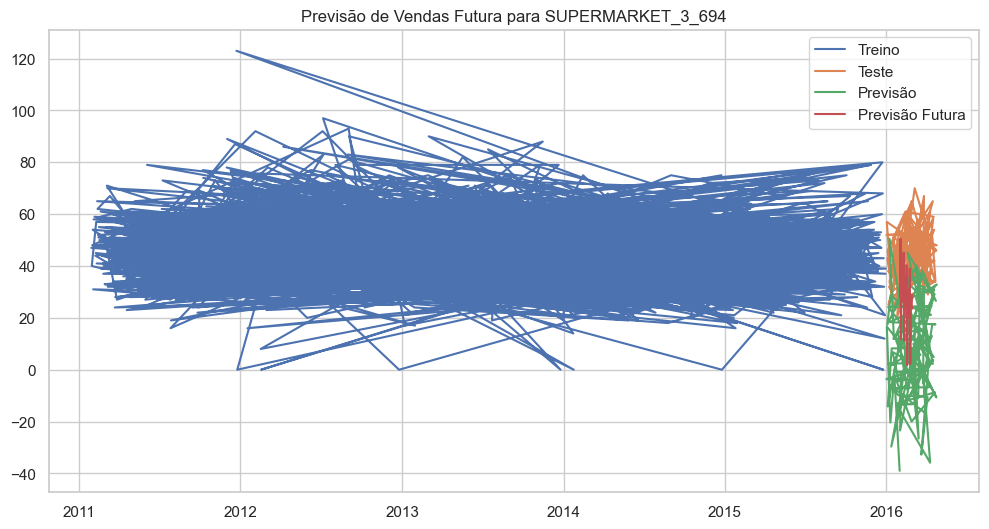


Treinando modelo para o item: SUPERMARKET_3_226

Verificando estacionariedade para o item: SUPERMARKET_3_226
Estatística ADF: -41.576373584286884
p-value: 0.0
Critério 1%: -3.4339942213257535
Critério 5%: -2.8631497209507284
Critério 10%: -2.567626963361616

Selecionando o melhor modelo para o item: SUPERMARKET_3_226
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7839.910
Date:                           Wed, 23 Oct 2024   AIC                          15691.819
Time:                                   15:33:17   BIC                          15724.759
Sample:                                        0   HQIC                         15703.982
                                          - 1798                                         
Covariance Type:                             opg  

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


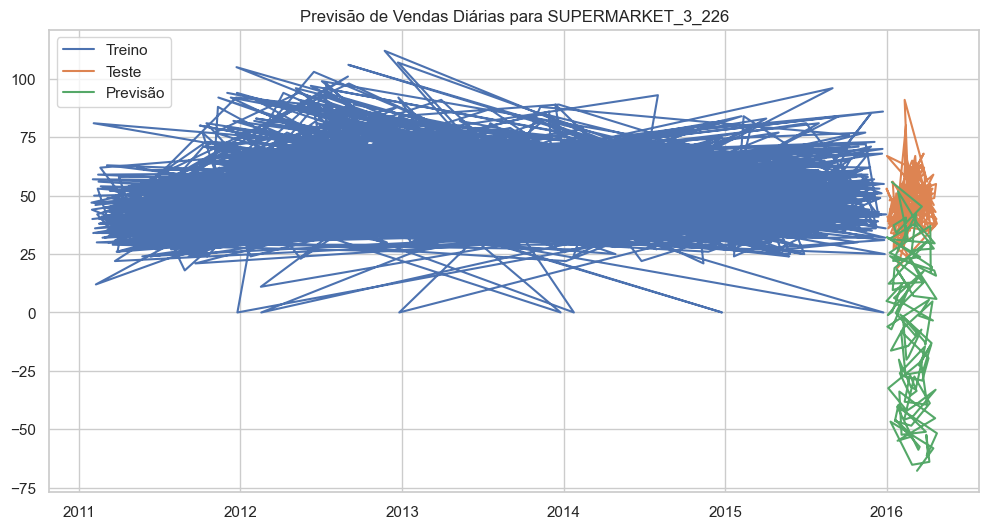

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


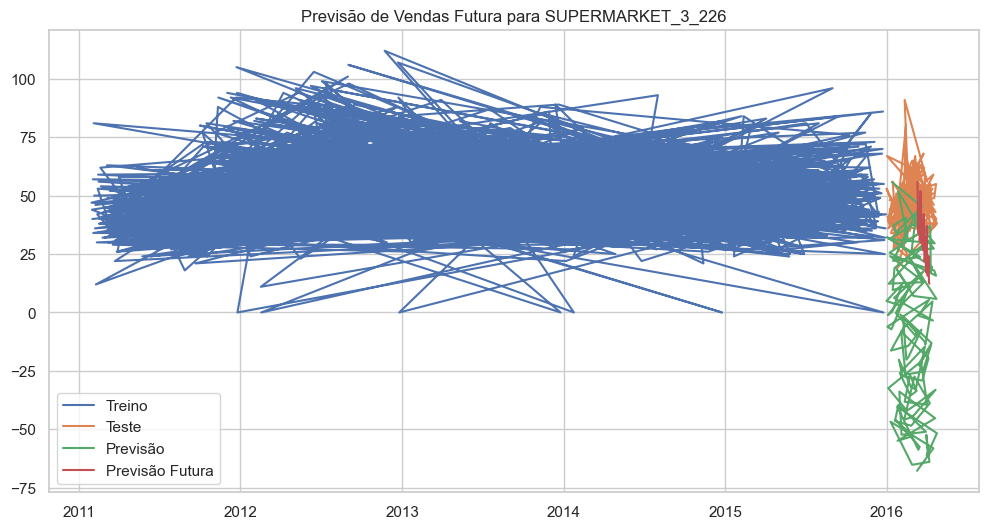


Treinando modelo para o item: SUPERMARKET_3_202

Verificando estacionariedade para o item: SUPERMARKET_3_202
Estatística ADF: -41.41271800048255
p-value: 0.0
Critério 1%: -3.4339942213257535
Critério 5%: -2.8631497209507284
Critério 10%: -2.567626963361616

Selecionando o melhor modelo para o item: SUPERMARKET_3_202
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -7051.967
Date:                           Wed, 23 Oct 2024   AIC                          14115.933
Time:                                   15:33:49   BIC                          14148.873
Sample:                                        0   HQIC                         14128.096
                                          - 1798                                         
Covariance Type:                             opg   

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


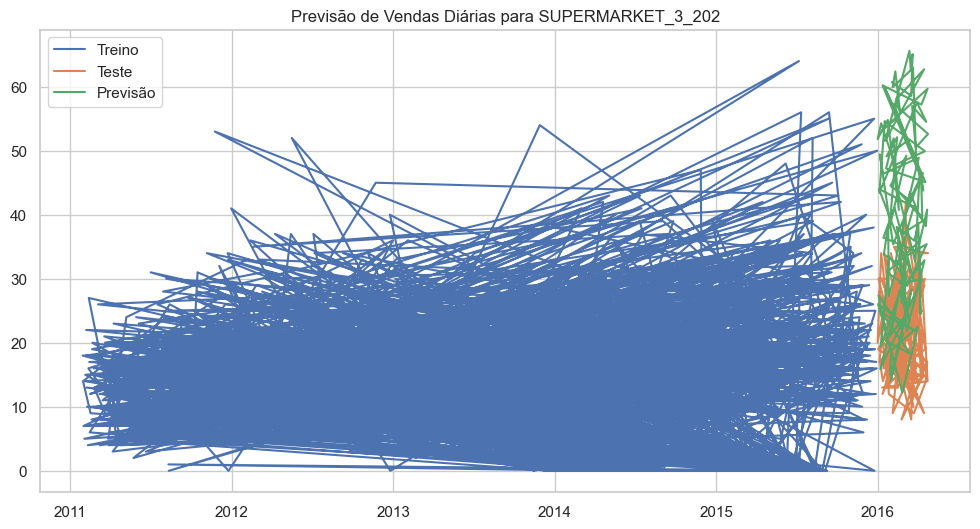

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


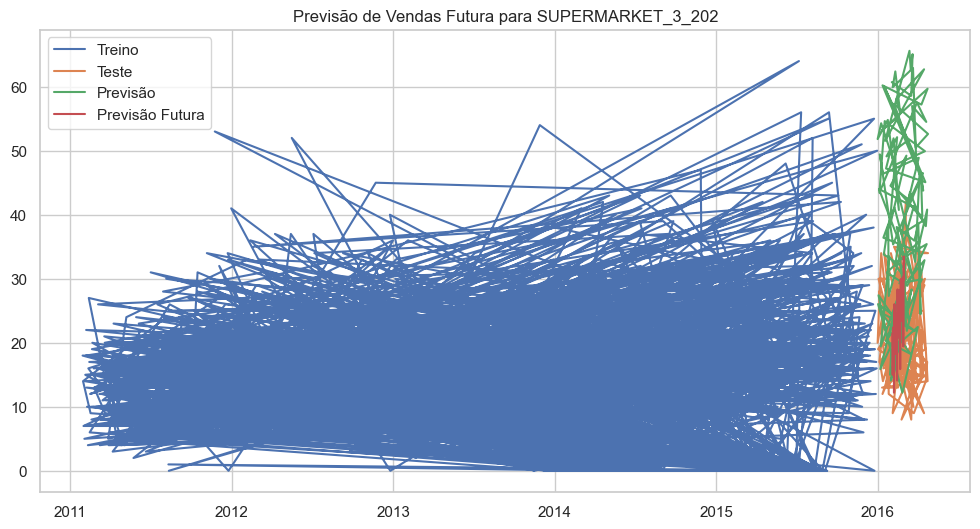


Treinando modelo para o item: SUPERMARKET_3_723

Verificando estacionariedade para o item: SUPERMARKET_3_723
Estatística ADF: -40.80833329951556
p-value: 0.0
Critério 1%: -3.4339942213257535
Critério 5%: -2.8631497209507284
Critério 10%: -2.567626963361616

Selecionando o melhor modelo para o item: SUPERMARKET_3_723
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1798
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -8284.499
Date:                           Wed, 23 Oct 2024   AIC                          16580.999
Time:                                   15:34:15   BIC                          16613.938
Sample:                                        0   HQIC                         16593.161
                                          - 1798                                         
Covariance Type:                             opg   

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


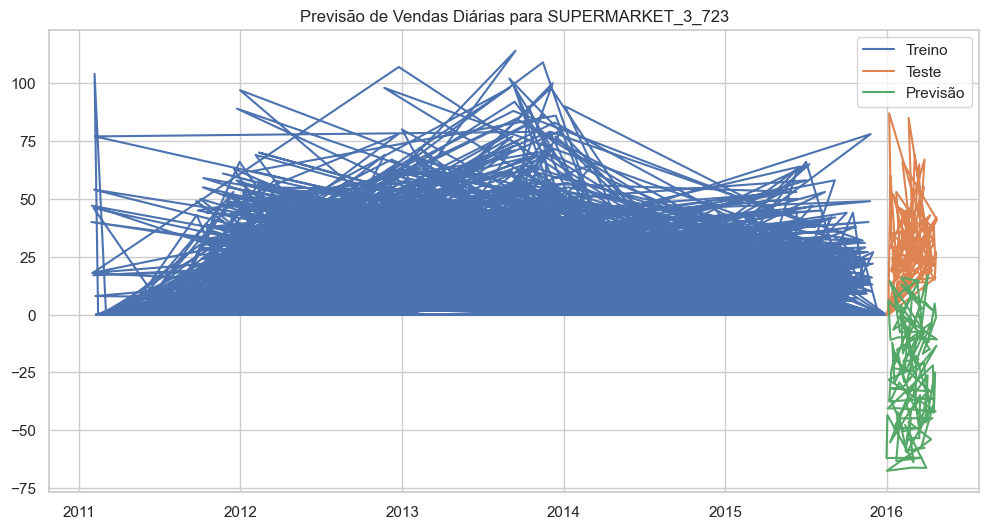

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


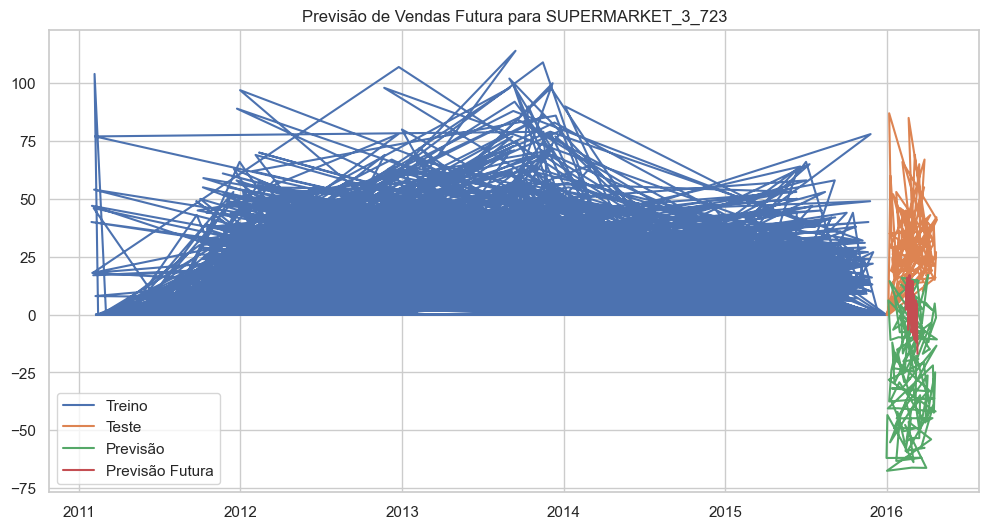

In [13]:
# Criar um dicionário para armazenar as previsões futuras
future_forecasts = {}

for item in top_items:
    print(f'\nTreinando modelo para o item: {item}')
    item_data = daily_sales[daily_sales['item'] == item].copy()
    forecast = train_and_forecast(item_data, item)
    future_forecasts[item] = forecast

## Análise dos Resultados

In [14]:
# Exibir a previsão futura para um item específico
item_to_view = top_items[0]  # Primeiro item da lista
print(f'\nPrevisão para os próximos 28 dias para o item {item_to_view}:')
print(future_forecasts[item_to_view])


Previsão para os próximos 28 dias para o item SUPERMARKET_3_090:
                            forecast
date                                
2016-02-07 00:00:00+00:00  34.619085
2016-02-08 00:00:00+00:00  17.164683
2016-02-09 00:00:00+00:00  39.133748
2016-02-10 00:00:00+00:00  29.931101
2016-02-11 00:00:00+00:00  31.866188
2016-02-12 00:00:00+00:00  16.803753
2016-02-13 00:00:00+00:00 -26.112927
2016-02-14 00:00:00+00:00  27.122222
2016-02-15 00:00:00+00:00 -26.562150
2016-02-16 00:00:00+00:00  15.488417
2016-02-17 00:00:00+00:00  38.554557
2016-02-18 00:00:00+00:00  12.049339
2016-02-19 00:00:00+00:00   0.410089
2016-02-20 00:00:00+00:00 -48.306376
2016-02-21 00:00:00+00:00 -11.615207
2016-02-22 00:00:00+00:00 -34.147023
2016-02-23 00:00:00+00:00   1.798356
2016-02-24 00:00:00+00:00  -5.727148
2016-02-25 00:00:00+00:00 -30.181269
2016-02-26 00:00:00+00:00 -26.073213
2016-02-27 00:00:00+00:00 -69.071313
2016-02-28 00:00:00+00:00 -27.226697
2016-02-29 00:00:00+00:00 -59.058967
2016-03-0

## Previsão com Prophet

In [19]:
def train_and_forecast_prophet(data, item_name):
    # Renomear as colunas para 'ds' e 'y' conforme esperado pelo Prophet
    data = data.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})

    # Converter 'ds' para datetime sem timezone
    data['ds'] = pd.to_datetime(data['ds']).dt.tz_localize(None)

    # Imprimir as colunas de data
    print("Colunas em data:", data.columns.tolist())

    # Identificar variáveis exógenas e remover 'event_NaN' se existir
    exog_vars = [col for col in data.columns if col.startswith('event_')]
    print("Variáveis exógenas antes da filtragem:", exog_vars)

    # Remover 'event_nan' se estiver na lista
    if 'event_nan' in exog_vars:
        exog_vars.remove('event_nan')

    print("Variáveis exógenas utilizadas:", exog_vars)

    # Garantir que as variáveis exógenas são numéricas e sem valores nulos
    for var in exog_vars:
        data[var] = pd.to_numeric(data[var], errors='coerce').fillna(0)

    # Verificar tipos de dados e valores nulos
    print("Tipos de dados das variáveis exógenas:")
    print(data[exog_vars].dtypes)
    print("Valores nulos nas variáveis exógenas:")
    print(data[exog_vars].isnull().sum())

    # Manter apenas as colunas necessárias
    required_columns = ['ds', 'y'] + exog_vars
    data = data[required_columns]

    # Treinar o modelo
    model = Prophet()

    # Adicionar regressores
    for var in exog_vars:
        model.add_regressor(var)

    # Treinar o modelo com os dados disponíveis
    model.fit(data)

    # Fazer previsões para os próximos 28 dias
    future = model.make_future_dataframe(periods=28, freq='D')

    # Adicionar variáveis exógenas futuras
    for var in exog_vars:
        future[var] = 0  # Inicialmente zero
        if var == 'event_Natal':
            future.loc[(future['ds'].dt.month == 12) & (future['ds'].dt.day == 25), var] = 1

    # Verificar o DataFrame future
    print("Colunas em future:", future.columns.tolist())
    print("Variáveis exógenas em future:")
    print(future[exog_vars].head())

    forecast = model.predict(future)

    # Plotar os resultados
    model.plot(forecast)
    plt.title(f'Previsão de Vendas para {item_name} usando Prophet')
    plt.show()

    # Plotar componentes
    model.plot_components(forecast)
    plt.show()

    # Retornar as previsões
    return forecast[['ds', 'yhat']].set_index('ds')


Previsão com Prophet para o item: SUPERMARKET_3_090
Colunas em data: ['ds', 'id', 'item', 'category_x', 'department', 'store', 'store_code', 'region', 'd', 'y', 'yearweek', 'category_y', 'sell_price', 'event_Easter', 'event_NewYear', 'event_Ramadan starts', 'event_SuperBowl', 'event_Thanksgiving', 'year', 'month']
Variáveis exógenas antes da filtragem: ['event_Easter', 'event_NewYear', 'event_Ramadan starts', 'event_SuperBowl', 'event_Thanksgiving']
Variáveis exógenas utilizadas: ['event_Easter', 'event_NewYear', 'event_Ramadan starts', 'event_SuperBowl', 'event_Thanksgiving']
Tipos de dados das variáveis exógenas:
event_Easter            bool
event_NewYear           bool
event_Ramadan starts    bool
event_SuperBowl         bool
event_Thanksgiving      bool
dtype: object
Valores nulos nas variáveis exógenas:
event_Easter            0
event_NewYear           0
event_Ramadan starts    0
event_SuperBowl         0
event_Thanksgiving      0
dtype: int64


15:34:17 - cmdstanpy - INFO - Chain [1] start processing
15:34:17 - cmdstanpy - INFO - Chain [1] done processing


Colunas em future: ['ds', 'event_Easter', 'event_NewYear', 'event_Ramadan starts', 'event_SuperBowl', 'event_Thanksgiving']
Variáveis exógenas em future:
   event_Easter  event_NewYear  event_Ramadan starts  event_SuperBowl  \
0             0              0                     0                0   
1             0              0                     0                0   
2             0              0                     0                0   
3             0              0                     0                0   
4             0              0                     0                0   

   event_Thanksgiving  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


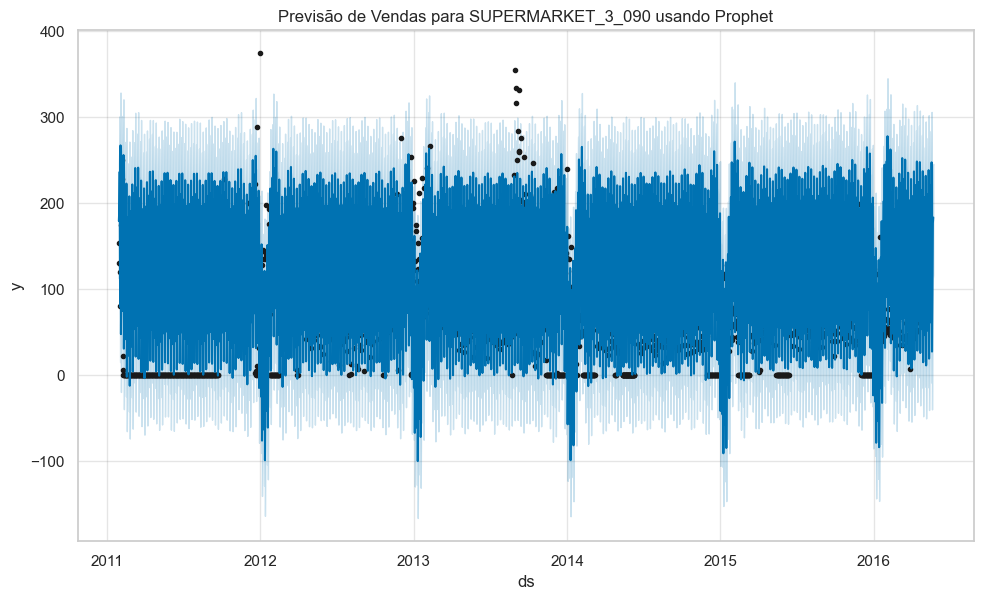

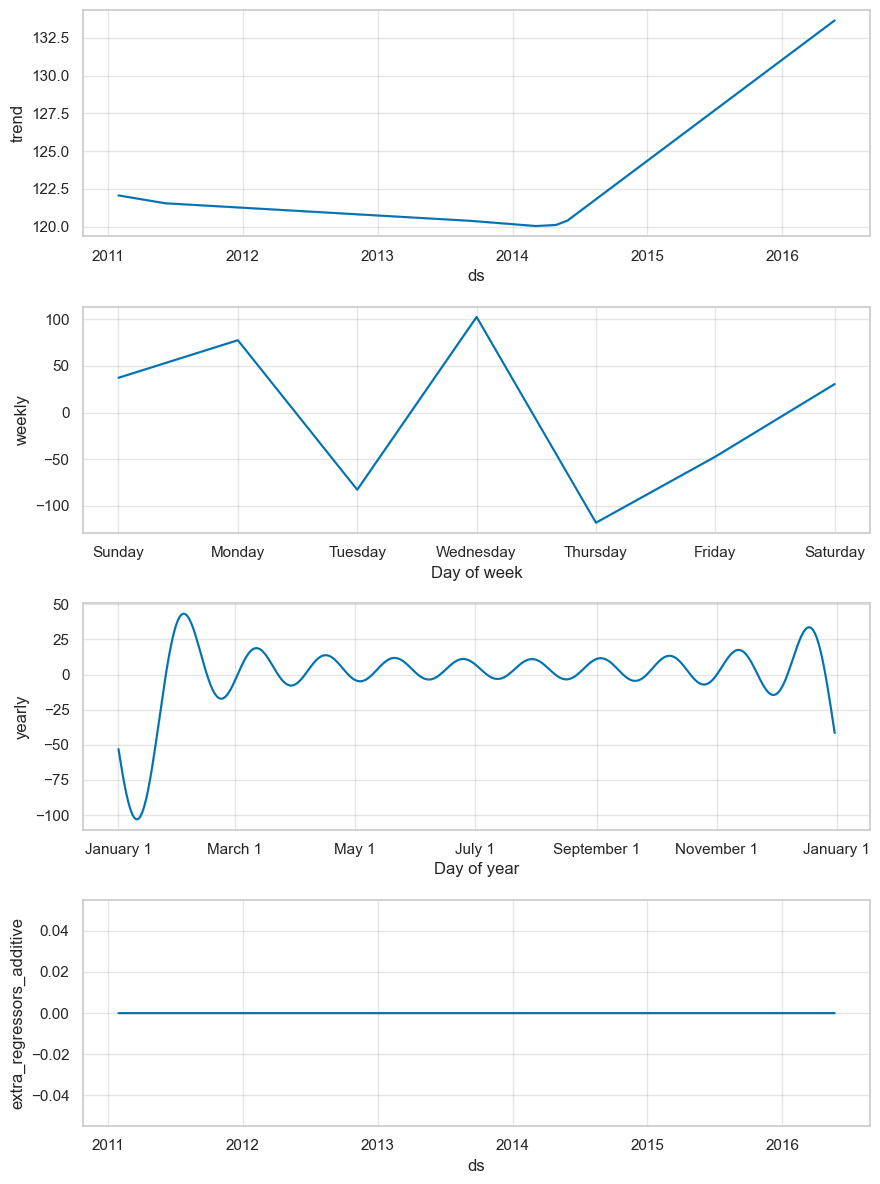

Previsões com Prophet para SUPERMARKET_3_090 salvas em forecast_prophet_SUPERMARKET_3_090.csv


In [16]:
# Aplicar a previsão com Prophet para um item
print(f'\nPrevisão com Prophet para o item: {item_to_view}')
item_data = daily_sales[daily_sales['item'] == item_to_view].copy()
forecast_prophet = train_and_forecast_prophet(item_data, item_to_view)

# Salvar as previsões do Prophet
forecast_prophet.to_csv(f'forecast_prophet_{item_to_view}.csv')
print(f'Previsões com Prophet para {item_to_view} salvas em forecast_prophet_{item_to_view}.csv')

## Salvar resultados

In [20]:
# Criar uma lista para armazenar todos os DataFrames de previsão
forecast_list = []

for item, forecast_df in future_forecasts.items():
    forecast_df = forecast_df.copy()
    forecast_df['item'] = item
    forecast_list.append(forecast_df)  # Adicionar o DataFrame à lista

# Concatenar todos os DataFrames em um único DataFrame
all_forecasts = pd.concat(forecast_list, ignore_index=True)

# Resetar o índice para facilitar a visualização
all_forecasts.reset_index(drop=True, inplace=True)

# Salvar em um arquivo CSV
all_forecasts.to_csv('all_forecasts.csv', index=False)
print('Todas as previsões salvas em all_forecasts.csv')

Todas as previsões salvas em all_forecasts.csv


# Interpretação

In [18]:
# Escolher um item para visualizar
item_to_view = top_items[0]  # Primeiro item da lista
print(f'\nPrevisão para os próximos 28 dias para o item {item_to_view}:')
print(future_forecasts[item_to_view])


Previsão para os próximos 28 dias para o item SUPERMARKET_3_090:
                            forecast
date                                
2016-02-07 00:00:00+00:00  34.619085
2016-02-08 00:00:00+00:00  17.164683
2016-02-09 00:00:00+00:00  39.133748
2016-02-10 00:00:00+00:00  29.931101
2016-02-11 00:00:00+00:00  31.866188
2016-02-12 00:00:00+00:00  16.803753
2016-02-13 00:00:00+00:00 -26.112927
2016-02-14 00:00:00+00:00  27.122222
2016-02-15 00:00:00+00:00 -26.562150
2016-02-16 00:00:00+00:00  15.488417
2016-02-17 00:00:00+00:00  38.554557
2016-02-18 00:00:00+00:00  12.049339
2016-02-19 00:00:00+00:00   0.410089
2016-02-20 00:00:00+00:00 -48.306376
2016-02-21 00:00:00+00:00 -11.615207
2016-02-22 00:00:00+00:00 -34.147023
2016-02-23 00:00:00+00:00   1.798356
2016-02-24 00:00:00+00:00  -5.727148
2016-02-25 00:00:00+00:00 -30.181269
2016-02-26 00:00:00+00:00 -26.073213
2016-02-27 00:00:00+00:00 -69.071313
2016-02-28 00:00:00+00:00 -27.226697
2016-02-29 00:00:00+00:00 -59.058967
2016-03-0